In [3]:
!pip install obonet --quiet

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import random
import networkx
import obonet
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
DEVICE = 'cuda'

In [5]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv", sep="\t")
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
ia_data = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/IA.txt", header=None, names=['term', 'ia'], sep='\t')
pid_to_idx = {train_protein_ids[idx]: idx for idx in range(train_protein_ids.shape[0])}
term_to_ia = {ia_data['term'].iloc[i]: ia_data['ia'].iloc[i] for i in range(len(ia_data))}
term_to_ia['BGN'] = 0


go_graph = obonet.read_obo('/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo')
go_graph.add_node('BGN')
for node, deg in dict(go_graph.out_degree()).items():
    if deg == 0 and node != 'BGN':
        go_graph.add_edge(node, 'BGN')
        print(node)

goh = list(networkx.topological_sort(go_graph))[::-1]
rnk = {k: i for i, k in enumerate(goh)}

BPO = train_terms[train_terms['aspect'] == 'BPO']['term'].value_counts()[:1600].index.tolist()
CCO = train_terms[train_terms['aspect'] == 'CCO']['term'].value_counts()[:600].index.tolist()
MFO = train_terms[train_terms['aspect'] == 'MFO']['term'].value_counts()[:800].index.tolist()
chosen_terms = set(['BGN']) | set(BPO) | set(CCO) | set(MFO)
chosen_terms = sorted(list(chosen_terms), key=lambda t: rnk[t])
go_ias = torch.tensor([term_to_ia[x] for x in chosen_terms], device=DEVICE)
term_ind = {k: i for i, k in enumerate(chosen_terms)}
PADDING_IDX = -1
term_ind['-'] = PADDING_IDX
TERM_CNT = len(term_ind)

chosen_rows = train_terms[train_terms['term'].isin(chosen_terms)]
entries = chosen_rows['EntryID'].unique().tolist()
entry_to_idx = {k: i for i, k in enumerate(entries)}

GO:0003674
GO:0005575
GO:0008150


In [36]:
class ProtDataset(Dataset):

    def __init__(self, agg_entries, CONTEXT_SIZE=100, transform=None, embeddings=None, emb_mapping=None):
        X_go, Y_all, Y_target, Y_meaningful, entries = [], [], [], [], []
        rev_graph = go_graph.reverse().subgraph(chosen_terms).copy()
        for row in tqdm(agg_entries.iterrows()):
            entry = row[0]
            gos = row[1]['targets'].split()
            all_gos = row[1]['term'].split() + ['BGN']
            all_gos_set = set(all_gos)

            Y_all.append([term_ind[t] for t in all_gos_set])
            ys = [[term_ind[n] for n in rev_graph.neighbors(t) if n in all_gos_set] for t in gos]
            Y_target.append(ys)
            ys = [[term_ind[n] for n in rev_graph.neighbors(t) if n in term_ind] for t in gos]
            Y_meaningful.append(ys)
            entries.append(entry)

            res = [term_ind[t] for t in gos][:CONTEXT_SIZE]
            while len(res) < CONTEXT_SIZE:
                res.append(PADDING_IDX)
            X_go.append(res)
        X_emb = torch.tensor(embeddings[[emb_mapping[pid] for pid, _ in agg_entries.iterrows()]], device=DEVICE).float()
        X_go = torch.tensor(X_go, device=DEVICE)
        self.X_go = X_go
        self.X_emb = X_emb
        self.entries = np.array(entries, dtype=list)
        self.Y_all = np.array(Y_all, dtype=list)
        self.Y_target = np.array(Y_target, dtype=list)
        self.Y_meaningful = np.array(Y_meaningful, dtype=list)

    def __len__(self):
        return self.X_go.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if not isinstance(idx, list):
            idx = [idx]

        
        return self.X_go[idx], self.X_emb[idx], self.Y_all[idx].tolist(), self.Y_target[idx].tolist(), self.Y_meaningful[idx].tolist(), self.entries[idx].tolist()

        if self.transform:
            sample = self.transform(sample)

        return sample
def simple_collate_fn(batch):
    x_go = torch.stack([sample[0] for sample in batch]).squeeze(1)
    x_emb = torch.stack([sample[1] for sample in batch]).squeeze(1)
    y_all = [sample[2][0] for sample in batch]
    y_target = [sample[3][0] for sample in batch]
    y_meaningful = [sample[4][0] for sample in batch]
    entries = [sample[5][0] for sample in batch]
    return x_go, x_emb, y_all, y_target, y_meaningful, entries

In [145]:
CONTEXT_SIZE = 100
agg_entries = chosen_rows.groupby('EntryID').agg(lambda x: ' '.join(x))
agg_entries['targets'] = agg_entries.apply(lambda x: ' '.join(sorted(list(set(x['term'].split()) | set(['BGN', 'GO:0005575', 'GO:0003674', 'GO:0008150'])), key=lambda t: term_ind[t])[:CONTEXT_SIZE - 1]), axis=1)

In [146]:
dataset = ProtDataset(agg_entries, CONTEXT_SIZE=100, embeddings=train_embeddings, emb_mapping=pid_to_idx)
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataloader = DataLoader(val_dataset, batch_size=512, collate_fn=simple_collate_fn, shuffle=True, drop_last=True)
dataloader = DataLoader(train_dataset, batch_size=256, collate_fn=simple_collate_fn, shuffle=True, drop_last=True)

142246it [00:47, 2986.83it/s]


In [7]:
class CrossBlock(nn.Module):
    def __init__(self, embed_dim=32, cross_dim=1024, num_heads=4, dropout=0, *args, **kwargs):
        super(CrossBlock, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.kw, self.qw, self.vw = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.c_fc    = nn.Linear(embed_dim, 4 * embed_dim)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.ckw, self.cqw, self.cvw = nn.Linear(cross_dim, embed_dim * 4), nn.Linear(embed_dim, embed_dim), nn.Linear(cross_dim, embed_dim * 4)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln_3 = nn.LayerNorm(embed_dim)
        self.cross_dim = cross_dim
        self.embed_dim = embed_dim
    
    def forward(self, x, x_cross, return_weights=False):
        x = self.ln_1(x)
        x = x + self.attn(self.qw(x), self.kw(x), self.vw(x), is_causal=True)[0]
        x = self.ln_2(x)
        x = x + self.cross_attn(self.cqw(x), self.ckw(x_cross).reshape(-1, 4, self.embed_dim), self.cvw(x_cross).reshape(-1, 4, self.embed_dim))[0]
        x = self.ln_3(x)
        x = x + self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
        return x

class BaseModel(nn.Module):
    def __init__(self, go_vocab_size, emb_size=64):
        super(BaseModel, self).__init__()
        self.embed_go = nn.Embedding(go_vocab_size, emb_size)
        self.down = nn.Sequential(
            nn.Linear(1024, 128),
            nn.LayerNorm(128),
            nn.ReLU()
        )
        self.blocks = nn.ModuleList([
            CrossBlock(embed_dim=emb_size, cross_dim=128) for i in range(4)
        ])
        self.head = nn.Sequential(
            nn.Linear(emb_size, TERM_CNT)
        )
    
    def forward(self, x, emb_prot):
        x = self.embed_go(x + 1)
        for block in self.blocks:
            x = block(x, self.down(emb_prot))
        return self.head(x)

In [148]:
model = BaseModel(go_vocab_size=len(term_ind)).to(DEVICE)
print(f'param count: {sum(p.numel() for p in model.parameters())}')
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss(reduction='none')
train_losses = []
val_acc, val_recall = [], []

param count: 1116474


In [14]:
masks = torch.zeros((len(chosen_terms) + 1, len(chosen_terms) + 1), requires_grad=False, device=DEVICE)  # last row is used for padding
rev_graph = go_graph.reverse().subgraph(chosen_terms).copy()
for ind, g in tqdm(enumerate(chosen_terms)):
    masks[ind, [term_ind[n] for n in rev_graph.neighbors(g) if n in term_ind]] = 1

3001it [00:00, 19595.49it/s]


In [96]:
def validate_model(model, loader, threshold=0.5):
    model.eval()
    with torch.no_grad():
        cnt = 0
        acc = 0
        recall = 0
        probs = torch.zeros((loader.batch_size, TERM_CNT - 1), device=DEVICE)
        real = torch.zeros((loader.batch_size, TERM_CNT - 1), device=DEVICE)
        for x_go, x_emb, y_all, y_target, y_meaningful, entries in tqdm(loader):
            mk = masks[x_go].contiguous()
            probs = F.sigmoid(torch.nan_to_num((model(x_go, x_emb) * mk).sum(dim=1) / mk.sum(dim=1), nan=-1000)[:, :-1])
            real.fill_(0)
            
            for ind in range(len(y_all)):
                real[ind, y_all[ind]] = 1
            
            cnt += x_go.shape[0]
            acc += torch.nan_to_num(((probs * real > threshold) * go_ias).sum(dim=-1) / ((probs > threshold) * go_ias).sum(dim=-1), nan=1.0).sum()
            recall += torch.nan_to_num(((probs * real > threshold) * go_ias).sum(dim=-1) / ((real > 0.5) * go_ias).sum(dim=-1), nan=1.0).sum()   
    return acc / len(loader.dataset), recall / len(loader.dataset)

In [149]:
import time

A, B, C, D = 0, 0, 0, 0
epochs = 9
for i in range(epochs):
    for x_go, x_emb, y_all, y_target, y_meaningful, entries in tqdm(dataloader):
        a = time.time()
        model.train()
        res = model(x_go, x_emb)

        b = time.time()

        mk = masks[x_go].contiguous()
        res *= mk
        mks = mk.sum(dim=1)
        res = res.sum(dim=1) / torch.max(torch.tensor(1), mk.sum(dim=1))
        
        y = torch.zeros((x_go.shape[0], TERM_CNT), requires_grad=False, device=DEVICE)
        for bi, labels in enumerate(y_all):
            y[bi, labels] = 1
        
        c = time.time()

        loss = (F.binary_cross_entropy_with_logits(res, y, reduction='mean') * (mks > 0)).sum() / (mks > 0).sum()
        train_losses.append(loss.item())

        d = time.time()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        e = time.time()
        A += b - a
        B += c - b
        C += d - c
        D += e - d
    
    acc, recall = validate_model(model, val_dataloader)
    val_acc.append(acc.item())
    val_recall.append(recall.item())
    print(acc, recall)
    print(np.mean(train_losses[-500:]))

100%|██████████| 27/27 [00:03<00:00,  7.83it/s]


tensor(0.9282, device='cuda:0', dtype=torch.float64) tensor(0.7857, device='cuda:0', dtype=torch.float64)
0.638548890709877


100%|██████████| 27/27 [00:03<00:00,  7.86it/s]


tensor(0.9506, device='cuda:0', dtype=torch.float64) tensor(0.8891, device='cuda:0', dtype=torch.float64)
0.6307177461385727


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


tensor(0.9577, device='cuda:0', dtype=torch.float64) tensor(0.9270, device='cuda:0', dtype=torch.float64)
0.6290688321590424


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


tensor(0.9622, device='cuda:0', dtype=torch.float64) tensor(0.9394, device='cuda:0', dtype=torch.float64)
0.6283580138683319


100%|██████████| 27/27 [00:03<00:00,  7.81it/s]


tensor(0.9650, device='cuda:0', dtype=torch.float64) tensor(0.9451, device='cuda:0', dtype=torch.float64)
0.6279938039779663


100%|██████████| 27/27 [00:03<00:00,  7.67it/s]


tensor(0.9660, device='cuda:0', dtype=torch.float64) tensor(0.9502, device='cuda:0', dtype=torch.float64)
0.6277730875015258


100%|██████████| 27/27 [00:03<00:00,  7.91it/s]


tensor(0.9675, device='cuda:0', dtype=torch.float64) tensor(0.9516, device='cuda:0', dtype=torch.float64)
0.6276327908039093


100%|██████████| 27/27 [00:03<00:00,  7.90it/s]


tensor(0.9650, device='cuda:0', dtype=torch.float64) tensor(0.9550, device='cuda:0', dtype=torch.float64)
0.6275352991819382


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]

tensor(0.9663, device='cuda:0', dtype=torch.float64) tensor(0.9555, device='cuda:0', dtype=torch.float64)
0.6274590716362


In [265]:
torch.save(model.state_dict(), 'model-9epoch.pth')

In [151]:
tmp = torch.tensor([A, B, C, D])
tmp / tmp.sum()

tensor([0.0952, 0.3459, 0.0088, 0.5500])

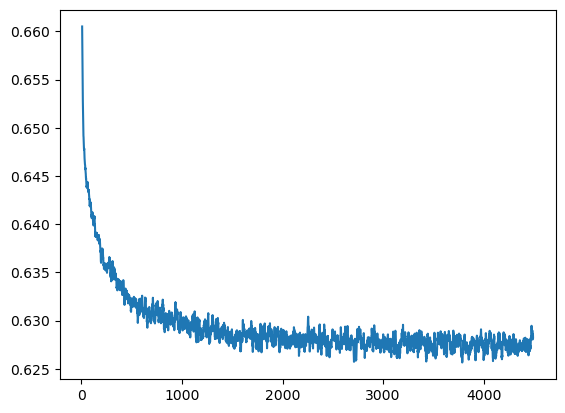

In [152]:
plt.plot(pd.Series(train_losses[10:]).rolling(10).mean())

In [15]:
# using contrastive learning on heirarchical structure
# using transformer to predict the child of the last node

In [39]:
model = BaseModel(go_vocab_size=len(term_ind)).to(DEVICE)
print(f'param count: {sum(p.numel() for p in model.parameters())}')
model.load_state_dict(torch.load('model-9epoch.pth'))

param count: 1116474


<All keys matched successfully>

In [38]:
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')
test_pid_to_idx = {test_protein_ids[idx]: idx for idx in range(test_protein_ids.shape[0])}
test_rows = train_terms[train_terms['EntryID'].isin(test_protein_ids) & train_terms['term'].isin(chosen_terms)]

In [40]:
data = {
    'EntryID': test_protein_ids.tolist(),
    'term': ['BGN'] * len(test_protein_ids),
    'aspect': ['None'] * len(test_protein_ids)
}
df_helper = pd.DataFrame(data)
test_rows = pd.concat([test_rows, df_helper])

In [41]:
CONTEXT_SIZE = 200
test_agg_entries = test_rows.groupby('EntryID').agg(lambda x: ' '.join(x))
test_agg_entries['targets'] = test_agg_entries.apply(lambda x: ' '.join(sorted(x['term'].split(), key=lambda t: term_ind[t])[:CONTEXT_SIZE]), axis=1)

In [43]:
test_dataset = ProtDataset(test_agg_entries, CONTEXT_SIZE=200, embeddings=test_embeddings, emb_mapping=test_pid_to_idx)
test_dataloader = DataLoader(test_dataset, batch_size=512, collate_fn=simple_collate_fn, shuffle=False)

141864it [00:41, 3453.94it/s]


In [45]:
import copy

model.eval()
generation_cycle = 5
prot_id = []
predictions = []
prediction_scores = []
rev_graph = go_graph.reverse().subgraph(chosen_terms).copy()
with torch.no_grad():
    for x_go, x_emb, y_all, y_target, y_meaningful, entries in tqdm(test_dataloader):
        probs = torch.zeros((x_go.shape[0], TERM_CNT), device=DEVICE)
        probs[torch.arange(x_go.shape[0]).unsqueeze(1), x_go] = 1.0
        probs[:, -1] = 0
        y_all_cop = copy.deepcopy(y_all)
        force_add = [term_ind[x] for x in ['GO:0003674', 'GO:0005575', 'GO:0008150']]  # main 3 subontologies
        
        for _ in range(generation_cycle):
            res = model(x_go, x_emb)
            mk = masks[x_go].contiguous()
            res *= mk
            mks = mk.sum(dim=1)
            #print(F.sigmoid(res[:, 0, :])[torch.arange(512).unsqueeze(1), masks[0].bool()])
            
            res = F.sigmoid(res.sum(dim=1) / torch.max(torch.tensor(1), mks)) * (mks > 0)
            #print(res[torch.arange(512).unsqueeze(1), masks[0].bool()])
            
            probs = torch.max(probs, res)
            
            for ind in range(len(y_all_cop)):
                tars = (probs[ind] > 0.9).sum().item()
                y_all_set = set(y_all_cop[ind])
                
                candidates = set(force_add)
                probs_sorted = probs.argsort(dim=-1, descending=True)
                for idx, x in enumerate(probs_sorted[ind, :tars].cpu().numpy().tolist()):
                    candidates.add(x)
                candidates = sorted(list(candidates - y_all_set))
                
                for t in candidates:
                    nid = len(y_all[ind])
                    if nid >= CONTEXT_SIZE:
                        break
                    x_go[ind, nid] = t
                    y_all_cop[ind].append(x)
                
        # print(probs[[0], masks[0].bool()])
        probs_sorted = probs.argsort(dim=-1, descending=True)
        for ind in range(len(y_all)):
            y_all_set = set(y_all[ind])
            tars = (probs[ind] > 0.1).sum().item()

            targets = set(force_add) | y_all_set
            any_new = False
            for idx, x in enumerate(probs_sorted[ind, :].cpu().numpy().tolist()):
                targets.add(x)
                if x not in y_all_set:
                    any_new = True
                if idx >= tars and any_new:
                    break
            targets = list(targets - set([0]))
            
            prot_id.append(entries[ind])
            predictions.append(targets[:1450])
            prediction_scores.append(probs[ind, targets[:1450]])

100%|██████████| 278/278 [09:53<00:00,  2.14s/it]


In [247]:
for i in range(10):
    #print(test_agg_entries['targets'].apply(lambda x: [term_ind[t] for t in x.split()]).iloc[0])
    #print(test_agg_entries['term'].apply(lambda x: [term_ind[t] for t in x.split()]).iloc[0])
    print(np.unique(test_agg_entries.iloc[i]['aspect'].split()).tolist(), end=" : ")
    for pred in predictions[i]:
        print(go_graph.nodes[chosen_terms[pred]]['namespace'], end=' ')
    print()

['BPO'] : cellular_component biological_process molecular_function 
['CCO'] : biological_process molecular_function 
['CCO'] : biological_process molecular_function 
['BPO', 'MFO'] : cellular_component molecular_function 
['BPO', 'CCO'] : biological_process biological_process molecular_function 
['CCO'] : biological_process cellular_component cellular_component molecular_function 
['CCO'] : biological_process molecular_function 
['CCO'] : biological_process molecular_function 
['MFO'] : cellular_component biological_process 
['BPO', 'CCO', 'MFO'] : cellular_component biological_process cellular_component 


In [46]:
data = {
    'protein_ids': [],
    'GO_term': [],
    'score': []
}
for idx, prot in tqdm(enumerate(prot_id)):
    for pidx, pred in enumerate(predictions[idx][:100]):
        if pred == 0:
            continue
        data['protein_ids'].append(prot)
        data['GO_term'].append(goh[pred])
        data['score'].append(max(0.001, round(prediction_scores[idx][pidx].item(), 3)))
submission = pd.DataFrame(data)

141864it [01:06, 2128.92it/s]


In [47]:
submission.to_csv('submission.tsv', sep='\t', header=False, index=False)

In [48]:
submission

,protein_ids,GO_term,score
0,A0A023PXA5,GO:0005575,0.001
1,A0A023PXA5,GO:0110165,0.001
2,A0A023PXA5,GO:0008150,0.915
3,A0A023PXA5,GO:0003674,1.000
4,A0A023PXB0,GO:0005575,0.001
...,...,...,...
3300433,X6R8D5,GO:0003674,1.000
3300434,X6R8R1,GO:0005575,0.001
3300435,X6R8R1,GO:0110165,0.011
3300436,X6R8R1,GO:0008150,0.752


<Axes: >

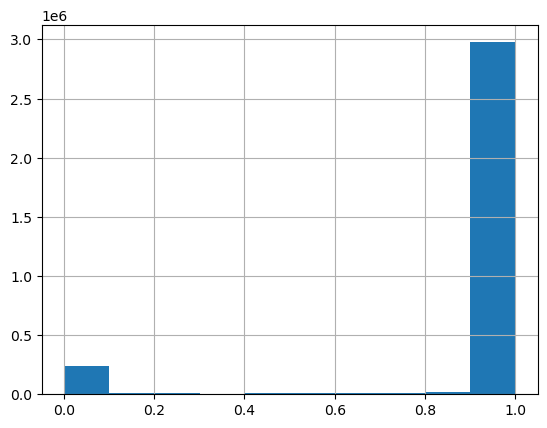

In [49]:
submission['score'].hist()